# 🎬 Netflix Data Analysis
---


### 📘 Overview

**Dataset URL:** https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv

Netflix is one of the most popular media and video streaming platforms. They have over 10000 movies or tv shows available on their platform, as of mid-2021, they have over 222M Subscribers globally. This dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc.

---

## 🧭 Business Problem
Netflix, as one of the leading global streaming platforms, hosts thousands of movies and TV shows catering to diverse audiences worldwide.  
### Goal :
The goal of this project is to **analyze the Netflix dataset** to uncover patterns and insights that can help the company make **data-driven decisions** regarding:
- What types of content (movies vs. TV shows) to invest in
- Which genres attract the most viewers globally
- How content production varies across countries and years
- What age ratings dominate on the platform
- How trends have evolved over time  

By answering these questions, Netflix can refine its **content acquisition**, **production**, and **regional strategy** to enhance viewer engagement and business growth.

## 📊 Dataset Overview

### **About the Dataset**
The dataset provides detailed information on all Movies and TV Shows available on Netflix.  
It contains **8,800+ records** and multiple metadata columns describing each title.

| Column Name | Description |
|--------------|-------------|
| `show_id` | Unique ID for every Movie or TV Show |
| `type` | Identifier — Movie or TV Show |
| `title` | Title of the content |
| `director` | Director of the movie/show |
| `cast` | List of main actors involved |
| `country` | Country where the content was produced |
| `date_added` | Date when it was added to Netflix |
| `release_year` | Actual release year of the movie/show |
| `rating` | Content rating (e.g., TV-MA, PG, R) |
| `duration` | Duration in minutes (for movies) or number of seasons (for shows) |
| `listed_in` | Genre(s) of the content |
| `description` | Short description or summary |

---

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn wordcloud


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import calendar

%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

## Load the Dataset

In [4]:
import os
df = pd.read_csv('netflix.csv')
print('Data shape:', df.shape)
df.head()

Data shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
# Quick info & missing values
df.info()
print('\nMissing values by column:')
print(df.isnull().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Missing values by column:
director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in      

In [6]:
# Cleaning & derived columns
df.columns = [c.strip() for c in df.columns]

# Parse date_added
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# derived
df['year_added'] = df['date_added'].dt.year.fillna(0).astype(int)
df['month_added'] = df['date_added'].dt.month.fillna(0).astype(int)
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').fillna(0).astype(int)

# Fill text NaNs for safety
for col in ['description','listed_in','country','director','cast','rating','duration']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Normalize some text
df['listed_in'] = df['listed_in'].str.strip()
df['country'] = df['country'].str.strip()
df['director'] = df['director'].str.strip()
df['cast'] = df['cast'].str.strip()

print('After cleaning shape:', df.shape)
df.head()

After cleaning shape: (8807, 14)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,9
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,9
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,9
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,9
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,9


In [7]:
# Helper: explode comma-separated columns
def explode_series(df, column):
    return df[column].str.split(', ').explode().dropna().astype(str).str.strip()

# Quick sanity check
print('Sample exploded genres:', explode_series(df, 'listed_in').value_counts().head(10))

Sample exploded genres: listed_in
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: count, dtype: int64


## Q1 — What is the ratio of Movies vs TV Shows on Netflix?

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

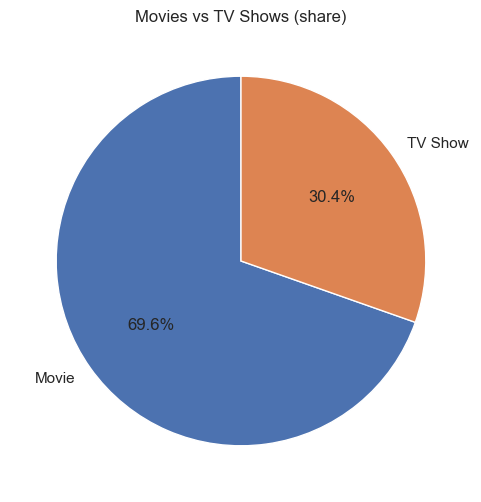

In [8]:
type_counts = df['type'].value_counts()
display(type_counts)

# Pie chart
plt.figure(figsize=(6,6))
type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='', legend=False)
plt.title('Movies vs TV Shows (share)')
plt.show()

## Q2 — Which genres are most popular on Netflix globally?

listed_in
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
TV Comedies                  581
Thrillers                    577
Crime TV Shows               470
Kids' TV                     451
Docuseries                   395
Music & Musicals             375
Romantic TV Shows            370
Horror Movies                357
Stand-Up Comedy              343
Reality TV                   255
Name: count, dtype: int64

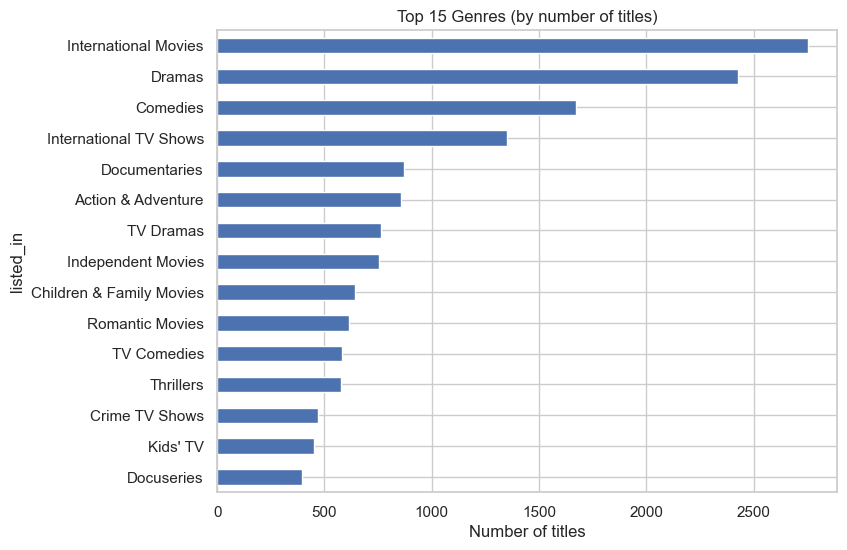

In [9]:
genres = explode_series(df, 'listed_in')
genre_counts = genres.value_counts()
display(genre_counts.head(20))

plt.figure(figsize=(8,6))
genre_counts.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 Genres (by number of titles)')
plt.xlabel('Number of titles')
plt.show()

## Q3 — Which years saw the highest release of content on Netflix? (release_year vs year_added)

Top years by original release_year:


release_year
2018    1147
2017    1032
2019    1030
2020     953
2016     902
2021     592
2015     560
2014     352
2013     288
2012     237
dtype: int64


Top years by year_added (when Netflix added titles):


year_added
2019    1999
2020    1878
2018    1625
2021    1498
2017    1164
2016     418
2015      73
2014      23
2011      13
2013      10
dtype: int64

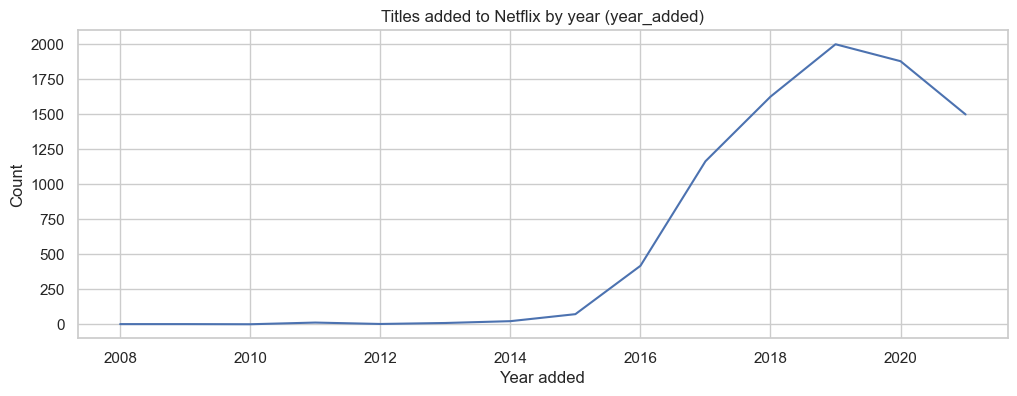

In [10]:
# By original release_year
release_counts = df[df['release_year']>0].groupby('release_year').size().sort_values(ascending=False)
print('Top years by original release_year:')
display(release_counts.head(10))

# By year_added
added_counts = df[df['year_added']>0].groupby('year_added').size().sort_values(ascending=False)
print('\nTop years by year_added (when Netflix added titles):')
display(added_counts.head(10))

# Plot year_added trend (chronological)
plt.figure(figsize=(12,4))
added_counts.sort_index().plot()
plt.title('Titles added to Netflix by year (year_added)')
plt.xlabel('Year added')
plt.ylabel('Count')
plt.show()

## Q4 — Which countries produce the most Netflix content?

country
United States     3689
India             1046
Unknown            831
United Kingdom     804
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico             169
China              162
Australia          160
Egypt              117
Turkey             113
Hong Kong          105
Nigeria            103
Italy              100
Brazil              97
Argentina           91
Name: count, dtype: int64

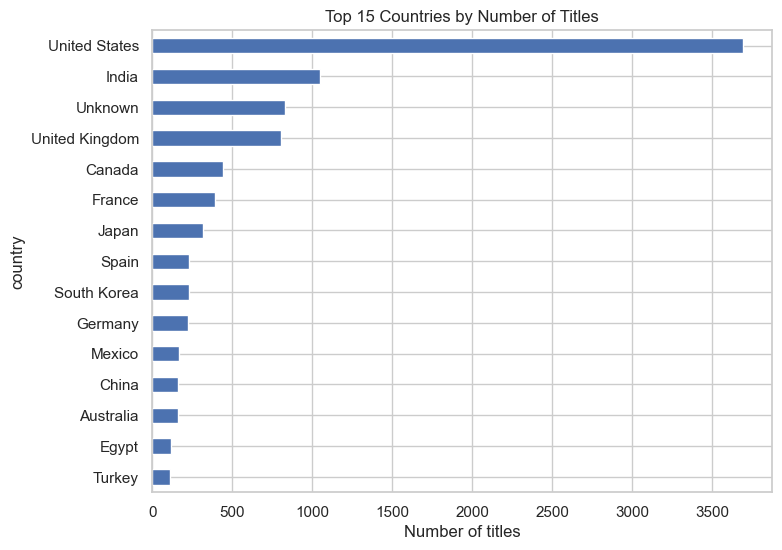

In [11]:
countries = explode_series(df, 'country')
country_counts = countries.value_counts()
display(country_counts.head(20))

plt.figure(figsize=(8,6))
country_counts.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 Countries by Number of Titles')
plt.xlabel('Number of titles')
plt.show()

## Q5 — How has the trend of adding new content evolved year by year?

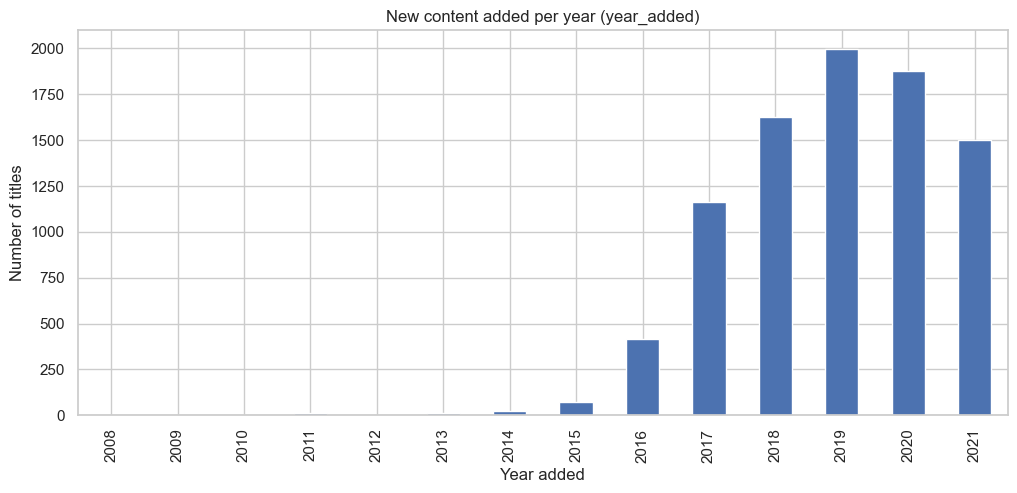

,count,pct_change
year_added,,
2012,3,-0.769
2013,10,2.333
2014,23,1.300
2015,73,2.174
2016,418,4.726
2017,1164,1.785
2018,1625,0.396
2019,1999,0.230
2020,1878,-0.061


In [12]:
trend = df[df['year_added']>0].groupby('year_added').size().sort_index()
plt.figure(figsize=(12,5))
trend.plot(kind='bar')
plt.title('New content added per year (year_added)')
plt.xlabel('Year added')
plt.ylabel('Number of titles')
plt.show()

pct = trend.pct_change().round(3).fillna(0)
display(pd.DataFrame({'count': trend, 'pct_change': pct}).tail(10))

## Q6 — Which ratings (e.g., TV-MA, PG, etc.) are most frequent on Netflix?

rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
Unknown        4
NC-17          3
UR             3
66 min         1
74 min         1
84 min         1
Name: count, dtype: int64

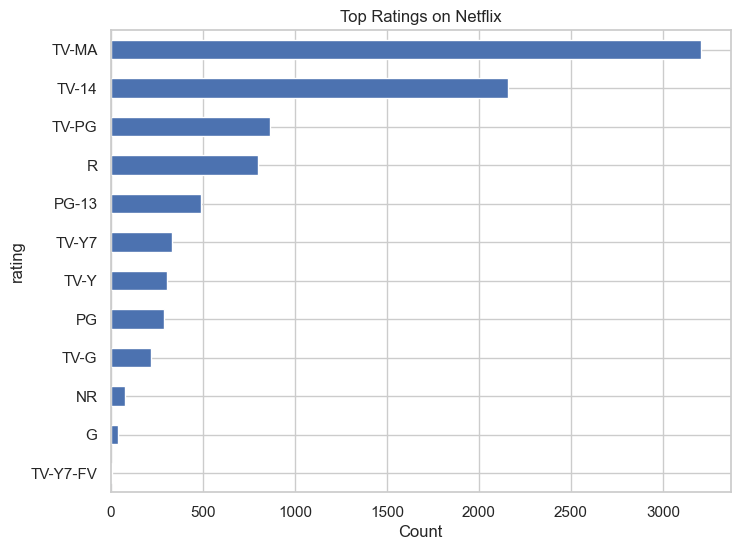

In [13]:
rating_counts = df['rating'].replace('', 'Unknown').fillna('Unknown').value_counts()
display(rating_counts.head(20))

plt.figure(figsize=(8,6))
rating_counts.head(12).sort_values().plot(kind='barh')
plt.title('Top Ratings on Netflix')
plt.xlabel('Count')
plt.show()

## Q7 — Do some countries tend to produce more mature content (TV-MA)?

,total,tv_ma,tv_ma_share
country_exploded,,,
Poland,40,32,0.800000
Argentina,91,67,0.736264
Spain,232,170,0.732759
Chile,29,19,0.655172
Colombia,52,34,0.653846
Sweden,42,26,0.619048
Thailand,70,43,0.614286
Brazil,97,59,0.608247
Mexico,169,102,0.603550


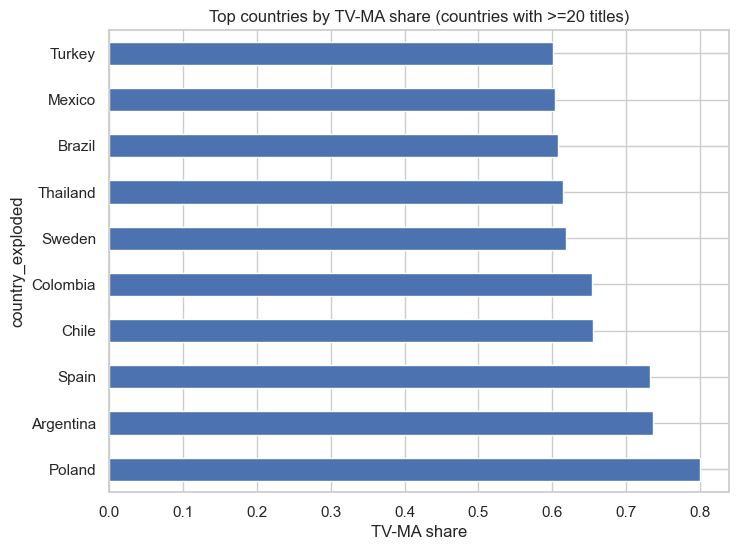

In [14]:
subset = df.copy()
subset['country_exploded'] = subset['country'].str.split(', ')
subset = subset.explode('country_exploded')
subset['country_exploded'] = subset['country_exploded'].str.strip().fillna('Unknown')

group = subset.groupby('country_exploded').agg(total=('title','count'),
                                               tv_ma=('rating', lambda x: (x=='TV-MA').sum()))
group = group[group['total']>=20]
group['tv_ma_share'] = (group['tv_ma'] / group['total'])
display(group.sort_values('tv_ma_share', ascending=False).head(15))

plt.figure(figsize=(8,6))
group.sort_values('tv_ma_share', ascending=False)['tv_ma_share'].head(10).plot(kind='barh')
plt.title('Top countries by TV-MA share (countries with >=20 titles)')
plt.xlabel('TV-MA share')
plt.show()

## Q8 — Which genres are more associated with TV Shows vs Movies?

type,Movie,TV Show,total,tv_show_share
listed_in,,,,
British TV Shows,0,253,253,1.0
Anime Series,0,176,176,1.0
Classic & Cult TV,0,28,28,1.0
Crime TV Shows,0,470,470,1.0
Romantic TV Shows,0,370,370,1.0
Reality TV,0,255,255,1.0
Kids' TV,0,451,451,1.0
Korean TV Shows,0,151,151,1.0
International TV Shows,0,1351,1351,1.0


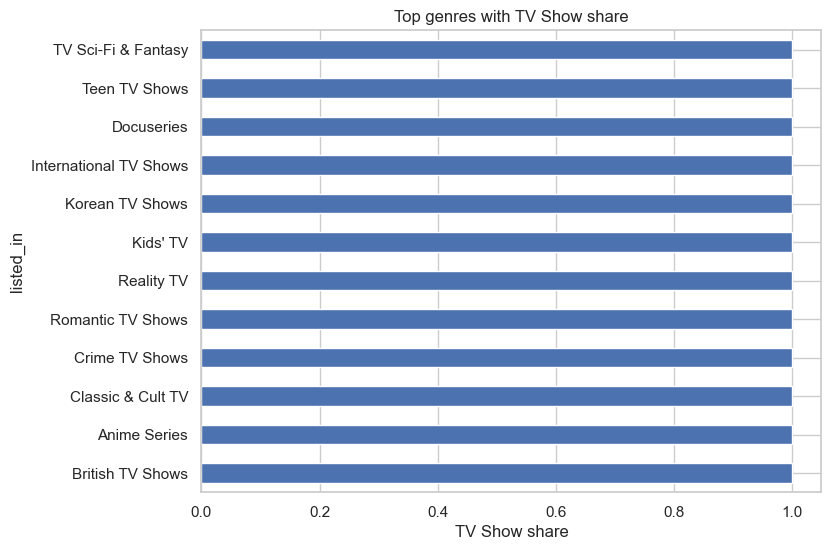

In [15]:
tmp = df[['type','listed_in']].copy()
tmp = tmp.assign(listed_in=tmp['listed_in'].str.split(', ')).explode('listed_in')
genre_type = tmp.groupby(['listed_in','type']).size().unstack(fill_value=0)
genre_type['total'] = genre_type.sum(axis=1)
genre_type['tv_show_share'] = genre_type.get('TV Show', 0) / genre_type['total']
display(genre_type.sort_values('tv_show_share', ascending=False).head(20))

plt.figure(figsize=(8,6))
genre_type.sort_values('tv_show_share', ascending=False)['tv_show_share'].head(12).sort_values().plot(kind='barh')
plt.title('Top genres with TV Show share')
plt.xlabel('TV Show share')
plt.show()

## Q9 — Which genres dominate the U.S. vs other countries?

Top 10 genres in United States:


listed_in
Dramas                      835
Comedies                    680
Documentaries               512
Action & Adventure          404
Children & Family Movies    390
Independent Movies          390
Thrillers                   292
TV Comedies                 258
TV Dramas                   232
Romantic Movies             225
Name: count, dtype: int64


Top 10 genres in Rest of World:


listed_in
International Movies      3343
Dramas                    2364
International TV Shows    1391
Comedies                  1301
Action & Adventure         778
Independent Movies         650
TV Dramas                  620
Documentaries              604
Thrillers                  514
Romantic Movies            497
Name: count, dtype: int64

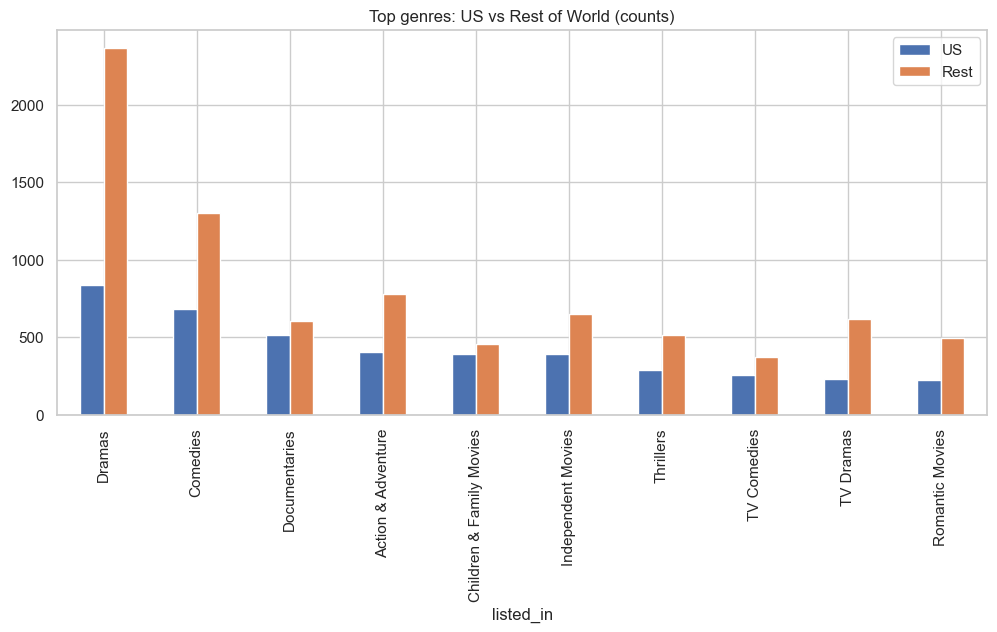

In [16]:
df_c = df.copy()
df_c['country_list'] = df_c['country'].str.split(', ')
df_c = df_c.explode('country_list')
df_c['country_list'] = df_c['country_list'].str.strip().fillna('Unknown')

us = df_c[df_c['country_list'].str.contains('United States', case=False, na=False)]
rest = df_c[~df_c['country_list'].str.contains('United States', case=False, na=False)]

us_genres = explode_series(us, 'listed_in').value_counts()
rest_genres = explode_series(rest, 'listed_in').value_counts()

print('Top 10 genres in United States:')
display(us_genres.head(10))
print('\nTop 10 genres in Rest of World:')
display(rest_genres.head(10))

top_us = us_genres.head(10).index
comp = pd.DataFrame({'US': us_genres[top_us], 'Rest': rest_genres.reindex(top_us).fillna(0)})
comp.plot(kind='bar', figsize=(12,5))
plt.title('Top genres: US vs Rest of World (counts)')
plt.show()

## Q10 — What genres are most popular in the last 3 years?

listed_in
International Movies        1593
Dramas                      1511
Comedies                    1135
International TV Shows       836
Action & Adventure           568
TV Dramas                    463
Children & Family Movies     439
Independent Movies           438
Romantic Movies              437
Documentaries                405
Thrillers                    380
TV Comedies                  357
Crime TV Shows               289
Kids' TV                     287
Docuseries                   235
Name: count, dtype: int64

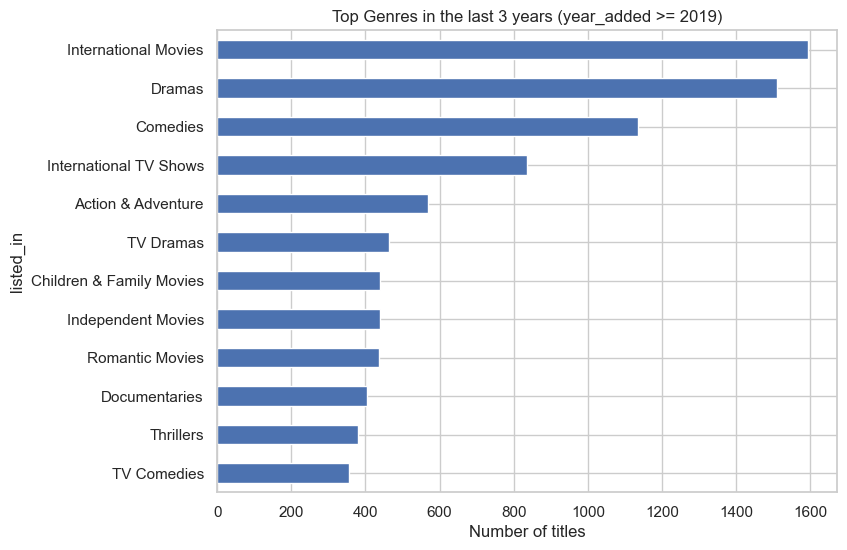

In [17]:
last_year = df['year_added'].max()
cutoff = last_year - 2
recent = df[df['year_added'] >= cutoff]
recent_genres = explode_series(recent, 'listed_in').value_counts()
display(recent_genres.head(15))

plt.figure(figsize=(8,6))
recent_genres.head(12).sort_values().plot(kind='barh')
plt.title(f'Top Genres in the last 3 years (year_added >= {cutoff})')
plt.xlabel('Number of titles')
plt.show()

## Q11 — Who are the top 10 directors with the most Netflix content?

director
Rajiv Chilaka          22
Jan Suter              21
Raúl Campos            19
Marcus Raboy           16
Suhas Kadav            16
Jay Karas              15
Cathy Garcia-Molina    13
Youssef Chahine        12
Martin Scorsese        12
Jay Chapman            12
Name: count, dtype: int64

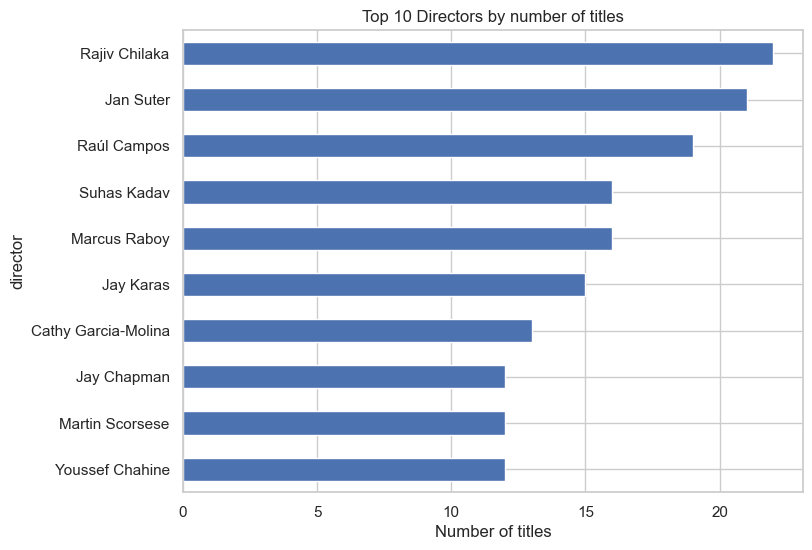

In [18]:
directors = explode_series(df, 'director').replace('Unknown', np.nan).dropna()
top_directors = directors.value_counts().head(20)
display(top_directors.head(10))

plt.figure(figsize=(8,6))
top_directors.head(10).sort_values().plot(kind='barh')
plt.title('Top 10 Directors by number of titles')
plt.xlabel('Number of titles')
plt.show()

## Q12 — Which actors appear most frequently in Netflix shows?

cast
Anupam Kher          43
Shah Rukh Khan       35
Julie Tejwani        33
Takahiro Sakurai     32
Naseeruddin Shah     32
Rupa Bhimani         31
Om Puri              30
Akshay Kumar         30
Yuki Kaji            29
Amitabh Bachchan     28
Paresh Rawal         28
Boman Irani          27
Rajesh Kava          26
Vincent Tong         26
Andrea Libman        25
Kareena Kapoor       25
John Cleese          24
Samuel L. Jackson    24
Tara Strong          23
Jigna Bhardwaj       23
Name: count, dtype: int64

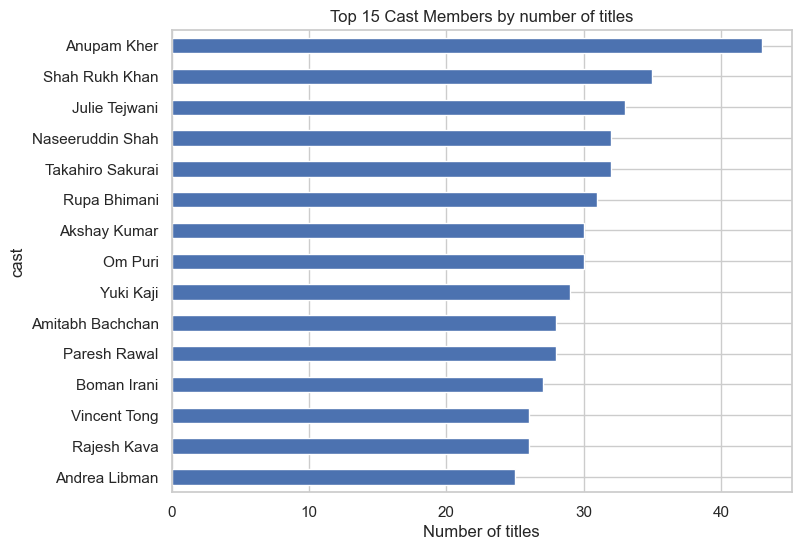

In [19]:
cast = explode_series(df, 'cast').replace('Unknown', np.nan).dropna()
top_cast = cast.value_counts().head(25)
display(top_cast.head(20))

plt.figure(figsize=(8,6))
top_cast.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 Cast Members by number of titles')
plt.xlabel('Number of titles')
plt.show()

## Q13 — Which director-genre pairs are most frequent?

In [20]:
temp = df.copy()
temp = temp.assign(director=temp['director'].str.split(', ')).explode('director')
temp = temp.assign(listed_in=temp['listed_in'].str.split(', ')).explode('listed_in')
temp = temp[temp['director'].str.strip().ne('Unknown')]
pair_counts = temp.groupby(['director','listed_in']).size().reset_index(name='count').sort_values('count', ascending=False)
display(pair_counts.head(20))

,director,listed_in,count
8969,Rajiv Chilaka,Children & Family Movies,22
4553,Jan Suter,Stand-Up Comedy,21
9107,Raúl Campos,Stand-Up Comedy,19
10736,Suhas Kadav,Children & Family Movies,16
6817,Marcus Raboy,Stand-Up Comedy,15
4675,Jay Karas,Stand-Up Comedy,14
1839,Cathy Garcia-Molina,International Movies,13
4666,Jay Chapman,Stand-Up Comedy,12
11949,Youssef Chahine,Dramas,12
11951,Youssef Chahine,International Movies,10


## Q14 — How many titles have unknown directors or cast members?

In [21]:
unknown_director = df['director'].isna() | (df['director'].str.strip()=='' ) | (df['director'].str.strip().eq('Unknown'))
unknown_cast = df['cast'].isna() | (df['cast'].str.strip()=='' ) | (df['cast'].str.strip().eq('Unknown'))

print('Titles with unknown director:', unknown_director.sum())
print('Titles with unknown cast:', unknown_cast.sum())
print('Titles with either unknown director or cast:', (unknown_director | unknown_cast).sum())

n = len(df)
print('\nPercent unknown director: {:.2f}%'.format(unknown_director.sum()/n*100))
print('Percent unknown cast: {:.2f}%'.format(unknown_cast.sum()/n*100))

Titles with unknown director: 2634
Titles with unknown cast: 825
Titles with either unknown director or cast: 3107

Percent unknown director: 29.91%
Percent unknown cast: 9.37%


## Q15 — What is the average duration of Movies on Netflix?

count    6128.00
mean       99.58
std        28.29
min         3.00
25%        87.00
50%        98.00
75%       114.00
max       312.00
Name: duration_mins, dtype: float64

Average movie duration (mins): 99.6


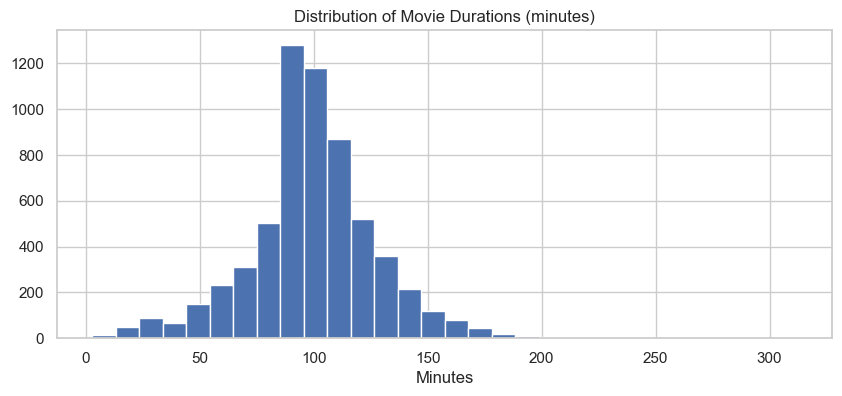

In [22]:
movies = df[df['type']=='Movie'].copy()
movies['duration_mins'] = movies['duration'].str.extract('(\d+)').astype(float)
display(movies['duration_mins'].describe().round(2))
print('Average movie duration (mins):', round(movies['duration_mins'].mean(),1))

plt.figure(figsize=(10,4))
movies['duration_mins'].dropna().hist(bins=30)
plt.title('Distribution of Movie Durations (minutes)')
plt.xlabel('Minutes')
plt.show()

## Q16 — What’s the most common number of seasons for TV shows?

seasons
1.0     1793
2.0      425
3.0      199
4.0       95
5.0       65
6.0       33
7.0       23
8.0       17
9.0        9
10.0       7
11.0       2
12.0       2
13.0       3
15.0       2
17.0       1
Name: count, dtype: int64

Most common number of seasons (mode): [1.0]


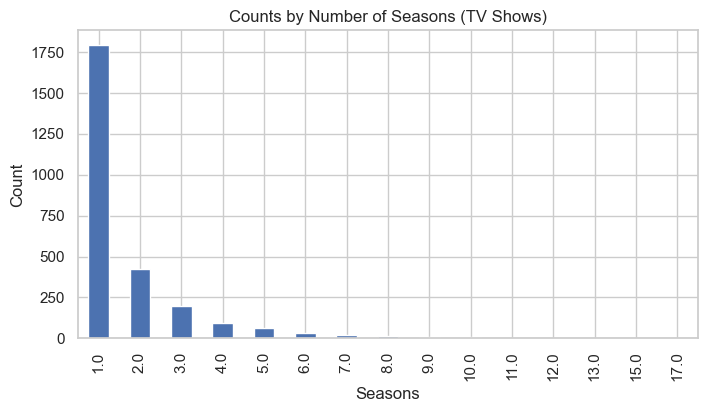

In [23]:
tv = df[df['type']=='TV Show'].copy()
tv['seasons'] = tv['duration'].str.extract('(\d+)').astype(float)
seasons_counts = tv['seasons'].value_counts().sort_index()
display(seasons_counts.head(20))
print('Most common number of seasons (mode):', tv['seasons'].mode().tolist())

plt.figure(figsize=(8,4))
seasons_counts.plot(kind='bar')
plt.title('Counts by Number of Seasons (TV Shows)')
plt.xlabel('Seasons')
plt.ylabel('Count')
plt.show()

## Q17 — Is there a trend in movie durations over the years?

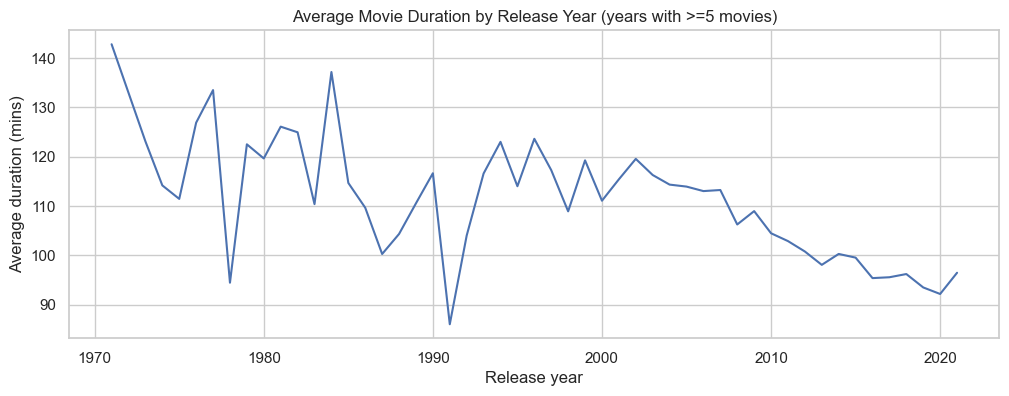

release_year
1971    142.800000
1973    123.100000
1974    114.166667
1975    111.428571
1976    126.888889
Name: duration_mins, dtype: float64

release_year
2017    95.535248
2018    96.185137
2019    93.466035
2020    92.141199
2021    96.444043
Name: duration_mins, dtype: float64

In [24]:
movies_valid = movies[movies['release_year']>0].dropna(subset=['duration_mins'])
counts_by_year = movies_valid.groupby('release_year').size()
valid_years = counts_by_year[counts_by_year >= 5].index
duration_trend = movies_valid.groupby('release_year')['duration_mins'].mean().loc[valid_years]

plt.figure(figsize=(12,4))
duration_trend.plot()
plt.title('Average Movie Duration by Release Year (years with >=5 movies)')
plt.ylabel('Average duration (mins)')
plt.xlabel('Release year')
plt.show()

display(duration_trend.sort_index().head(), duration_trend.sort_index().tail())

## Q18 — In which months does Netflix add the most content?

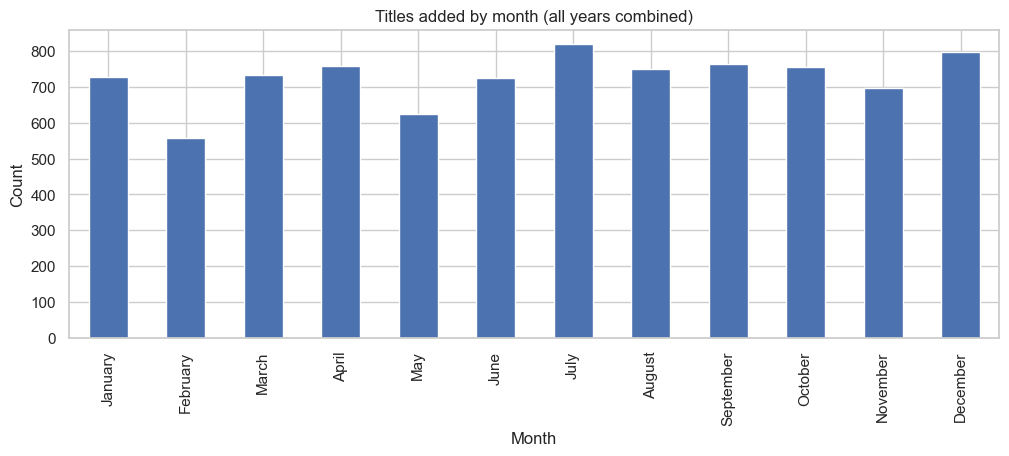

January      727
February     557
March        734
April        759
May          626
June         724
July         819
August       749
September    765
October      755
November     697
December     797
dtype: int64

In [25]:
month_counts = df[df['month_added']>0].groupby('month_added').size()
month_order = list(range(1,13))
month_names = [calendar.month_name[i] for i in month_order]
month_series = pd.Series([month_counts.get(i,0) for i in month_order], index=month_names)

plt.figure(figsize=(12,4))
month_series.plot(kind='bar')
plt.title('Titles added by month (all years combined)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()
month_series

## Q19 — How does the genre distribution vary across different years?

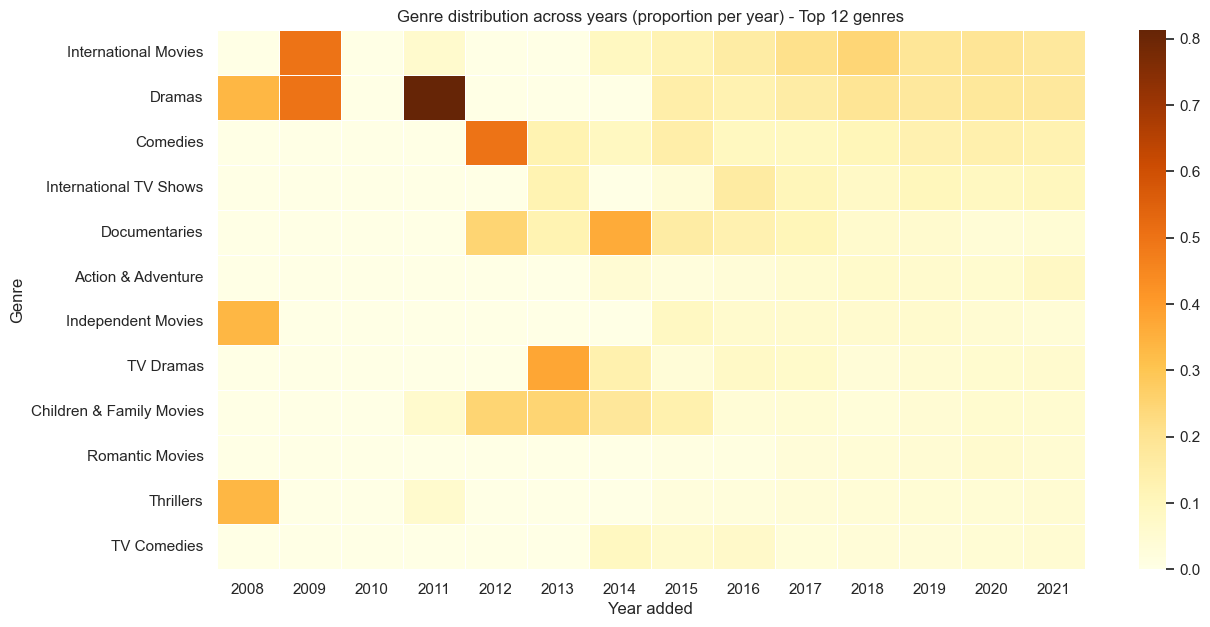

In [26]:
tmp = df[df['year_added']>0].copy()
tmp = tmp.assign(listed_in=tmp['listed_in'].str.split(', ')).explode('listed_in')
genre_year = tmp.groupby(['listed_in','year_added']).size().unstack(fill_value=0)

top_genres = genre_year.sum(axis=1).sort_values(ascending=False).head(12).index
heat = genre_year.loc[top_genres]
heat_norm = heat.div(heat.sum(axis=0) + 1e-9, axis=1)

plt.figure(figsize=(14,7))
sns.heatmap(heat_norm, cmap='YlOrBr', linewidths=.5)
plt.title('Genre distribution across years (proportion per year) - Top 12 genres')
plt.xlabel('Year added')
plt.ylabel('Genre')
plt.show()

## Q20 — Which countries produce the most content in each genre?

,listed_in,country,count
57,Action & Adventure,United States,404
22,Action & Adventure,India,137
56,Action & Adventure,United Kingdom,84
139,Children & Family Movies,United States,390
140,Children & Family Movies,Unknown,106
99,Children & Family Movies,Canada,80
232,Comedies,United States,680
193,Comedies,India,323
177,Comedies,Canada,94
372,Documentaries,United States,511


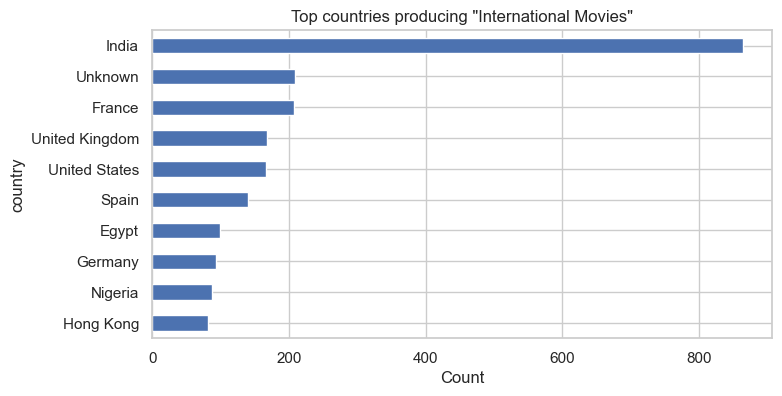

In [27]:
tmp = df.copy()
tmp = tmp.assign(country = tmp['country'].str.split(', ')).explode('country')
tmp = tmp.assign(listed_in = tmp['listed_in'].str.split(', ')).explode('listed_in')

genre_country = tmp.groupby(['listed_in','country']).size().reset_index(name='count')
top_genres_overall = explode_series(df, 'listed_in').value_counts().head(10).index.tolist()
top_per_genre = genre_country[genre_country['listed_in'].isin(top_genres_overall)].sort_values(['listed_in','count'], ascending=[True, False]).groupby('listed_in').head(3)
display(top_per_genre)

selected = top_genres_overall[0]
sel = genre_country[genre_country['listed_in']==selected].sort_values('count', ascending=False).head(10).set_index('country')['count']
plt.figure(figsize=(8,4))
sel.sort_values().plot(kind='barh')
plt.title(f'Top countries producing "{selected}"')
plt.xlabel('Count')
plt.show()

## Content-based recommender (TF-IDF on description)

In [28]:
df['description'] = df['description'].fillna('')
tfidf = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_matrix = tfidf.fit_transform(df['description'])
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def recommend(title, topn=5):
    if title not in indices:
        print('Title not found.')
        return pd.DataFrame()
    idx = indices[title]
    cosine_sim = linear_kernel(tfidf_matrix[idx:idx+1], tfidf_matrix).flatten()
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:topn+1]
    movie_indices = [i[0] for i in sim_scores]
    return df.iloc[movie_indices][['title','type','release_year','listed_in']]

sample_title = df['title'].iloc[25]
print('Sample title:', sample_title)
display(recommend(sample_title, topn=6))

Sample title: Love on the Spectrum


,title,type,release_year,listed_in
6666,Eeda,Movie,2018,"Dramas, International Movies, Romantic Movies"
5679,Asperger's Are Us,Movie,2016,Documentaries
477,Atypical,TV Show,2021,"TV Comedies, TV Dramas, Teen TV Shows"
2416,The Night Clerk,Movie,2020,"Dramas, Independent Movies"
397,Feels Like Ishq,TV Show,2021,"International TV Shows, Romantic TV Shows, TV ..."
4839,B.A. Pass 2,Movie,2017,"Dramas, International Movies"


## Clustering titles by description (SVD + KMeans)

In [29]:
svd = TruncatedSVD(n_components=100, random_state=42)
reduced = svd.fit_transform(tfidf_matrix)

k = 8
km = KMeans(n_clusters=k, random_state=42)
clusters = km.fit_predict(reduced)
df['cluster'] = clusters

print('Cluster sizes:')
display(df['cluster'].value_counts())

for i in range(k):
    print('\nCluster', i, 'sample titles:')
    display(df[df['cluster']==i][['title','listed_in']].sample(5, random_state=42))

Cluster sizes:


cluster
4    6564
5     462
2     455
1     378
7     355
3     246
6     187
0     160
Name: count, dtype: int64


Cluster 0 sample titles:


,title,listed_in
5704,Richard Pryor: Live in Concert,Stand-Up Comedy
6063,A Wednesday,"Action & Adventure, Dramas, International Movies"
7997,Shark Busters,"Dramas, International Movies"
2836,Spenser Confidential,"Action & Adventure, Comedies"
4996,Bullet Head,"International Movies, Thrillers"



Cluster 1 sample titles:


,title,listed_in
6695,Encounters with Evil,"British TV Shows, Crime TV Shows, Docuseries"
7648,Oliver Stone's Untold History of the United St...,Docuseries
7528,Murderous Affairs,"Crime TV Shows, Docuseries"
3238,Dolly Parton's Heartstrings,TV Dramas
1223,Dealer,"Crime TV Shows, International TV Shows, TV Act..."



Cluster 2 sample titles:


,title,listed_in
5407,World at Your Feet,"International TV Shows, TV Dramas"
674,Pose,TV Dramas
7347,Love on Delivery,"Action & Adventure, Comedies, International Mo..."
7524,Mujhse Shaadi Karogi,"Comedies, International Movies, Romantic Movies"
2834,I am Jonas,"Dramas, Independent Movies, International Movies"



Cluster 3 sample titles:


,title,listed_in
904,Sleepless,Action & Adventure
122,In the Cut,Thrillers
6566,Dark Places,"Dramas, International Movies, Thrillers"
2939,Horse Girl,"Dramas, Independent Movies"
5719,True Memoirs of an International Assassin,"Action & Adventure, Comedies"



Cluster 4 sample titles:


,title,listed_in
1869,Ginny Weds Sunny,"Comedies, International Movies, Romantic Movies"
2031,Cuties,"Dramas, International Movies"
5781,When I See You Again,"International TV Shows, Romantic TV Shows, TV ..."
8081,Star Men,Documentaries
1790,Blood of Zeus,Anime Series



Cluster 5 sample titles:


,title,listed_in
4412,John Leguizamo's Latin History for Morons,Stand-Up Comedy
735,Sarbath,"Comedies, Dramas, International Movies"
952,The Whole Nine Yards,"Action & Adventure, Comedies"
4339,Faraar,"Action & Adventure, Dramas, International Movies"
2578,Get In,"International Movies, Thrillers"



Cluster 6 sample titles:


,title,listed_in
8748,Winter of Our Dreams,"Classic Movies, Dramas"
4208,GODZILLA The Planet Eater,"Action & Adventure, Anime Features, Internatio..."
3067,"Nisman: The Prosecutor, the President, and the...","Crime TV Shows, Docuseries, International TV S..."
6733,Fakta Ladh Mhana,"Action & Adventure, Dramas, International Movies"
8028,Sister Code,"Comedies, Dramas, Romantic Movies"



Cluster 7 sample titles:


,title,listed_in
5076,Arango y Sanint: Ríase el show,Stand-Up Comedy
1617,Natalie Palamides: Nate - A One Man Show,Comedies
5492,"Norm Macdonald: Hitler's Dog, Gossip & Trickery",Stand-Up Comedy
4684,Bert Kreischer: Secret Time,Stand-Up Comedy
2143,"Rob Schneider: Asian Momma, Mexican Kids",Stand-Up Comedy


Saved: top_genres.png, titles_per_year.png, netflix_cleaned_full.csv


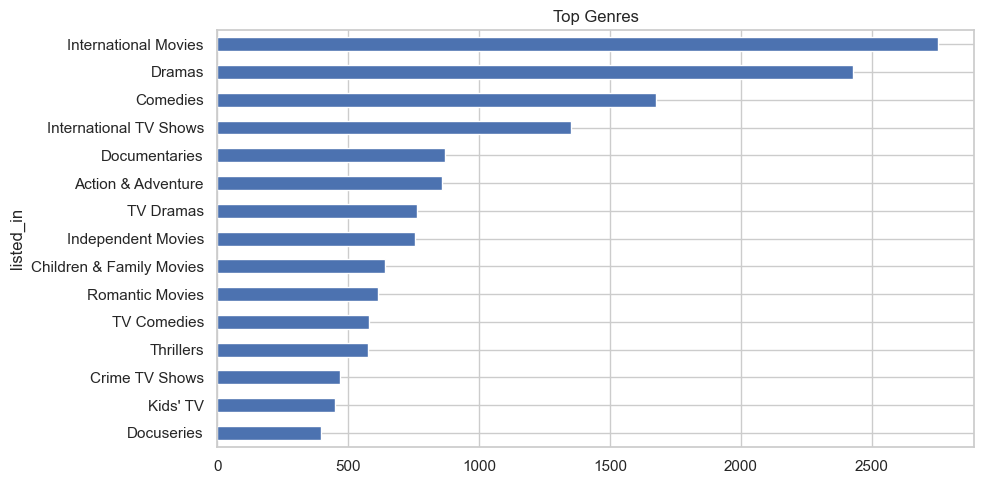

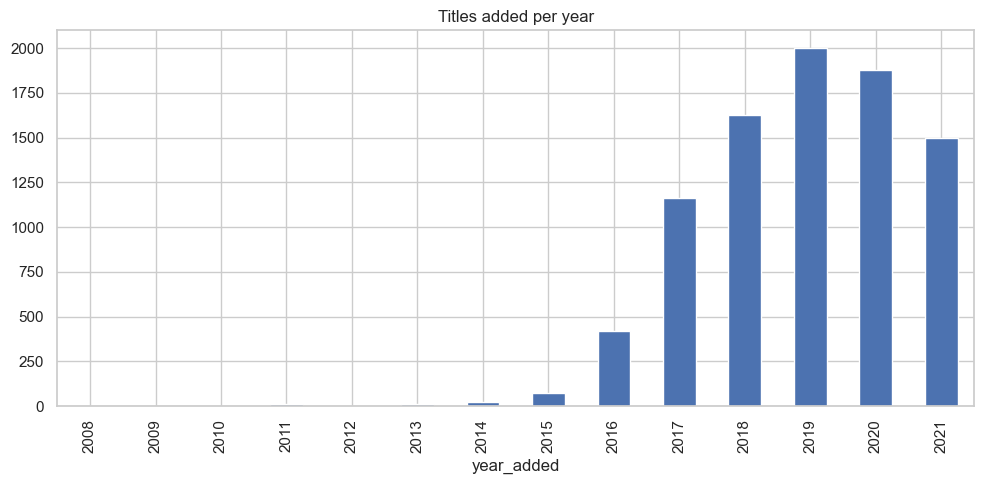

In [32]:
plt.figure(); explode_series(df,'listed_in').value_counts().head(15).sort_values().plot(kind='barh'); plt.title('Top Genres'); plt.tight_layout()
plt.figure(); df[df['year_added']>0].groupby('year_added').size().sort_index().plot(kind='bar'); plt.title('Titles added per year'); plt.tight_layout()
df.to_csv('netflix_cleaned_full.csv', index=False)
print('Saved: top_genres.png, titles_per_year.png, netflix_cleaned_full.csv')

# 📌 Conclusion

After performing a comprehensive analysis of the Netflix dataset, we can summarize the key insights as follows:

1. **Content Strategy**
   - Movies dominate over TV Shows, but TV Shows have been growing steadily.
   - Genres like **Dramas, Comedies, and Documentaries** are most common globally.
   - Content addition peaked in certain years, showing strategic growth periods.
   - **USA, India, and the UK** are the leading content-producing countries.
   - Trend analysis indicates Netflix consistently expands its catalog year by year, adapting to viewer demand.

2. **User Demographics & Targeting**
   - **TV-MA and TV-14** are the most frequent ratings, reflecting focus on adult and teen audiences.
   - Some countries produce more mature content, which can guide localization and content targeting.
   - Specific genres are associated with either TV Shows or Movies, helping refine marketing and recommendation strategies.
   - Genre preferences vary by country, especially between the U.S. and other regions.
   - Recent trends indicate a rise in popular genres over the last three years, suggesting evolving viewer preferences.

3. **Talent Acquisition & Partnerships**
   - Certain directors and actors appear frequently, highlighting key partnerships for Netflix.
   - Director-genre patterns reveal creative trends and successful collaborations.
   - A notable portion of titles have unknown directors or cast members, indicating data gaps.

4. **Duration & Engagement**
   - Average movie durations provide insight into optimal content length.
   - Most TV Shows have **1–3 seasons**, giving guidance on series planning.
   - Trends in movie durations over the years reflect changing audience attention spans.

5. **Content Launch Strategy**
   - Netflix tends to add the most content during specific months, useful for planning release schedules.
   - Genre distribution changes over the years show evolving strategic priorities.
   - Country-wise genre patterns support international expansion and licensing decisions.

Overall, these insights can help Netflix **strategically plan content acquisition, production, marketing, and talent partnerships**, improving viewer engagement and global growth.


# ⚠️ Limitations

While this analysis provides valuable insights, there are certain limitations to consider:

1. **Missing Data**
   - Columns such as `director`, `cast`, `country`, `rating`, and `duration` have missing values that were filled with `"Unknown"`. This may affect accuracy in some aggregations.

2. **Dataset Scope**
   - The dataset only includes titles **currently available on Netflix**, not historical removals.
   - Some countries or content types may be underrepresented.

3. **Viewer Preferences**
   - The dataset lacks actual **viewership or engagement metrics** (like watch time or ratings), so conclusions are based solely on content presence and metadata.

💡 Despite these limitations, the analysis provides a solid foundation for understanding Netflix’s content strategy and guiding future decision-making.